# TITANIC SURVIVAL PREDICTION PROJECT

In [1]:
!conda install conda-forge::streamlit -y
!conda install anaconda::joblib -y

Channels:
 - defaults
 - conda-forge
Platform: win-64
Solving environment: ...working... done

# All requested packages already installed.

Channels:
 - defaults
 - anaconda
Platform: win-64
Solving environment: ...working... done

# All requested packages already installed.



## Import libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import joblib
import streamlit as st

## 1. Data Loading & Exploration

In [3]:
url = "https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/titanic.csv"
df = pd.read_csv(url)

print("=== Initial Exploration ===")
print("Shape:", df.shape)
print("\nFirst 5 rows:")
display(df.head())
print("\nInfo:")
df.info()
print("\nSummary stats:")
display(df.describe(include='all'))


=== Initial Exploration ===
Shape: (887, 8)

First 5 rows:


,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887 entries, 0 to 886
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Survived                 887 non-null    int64  
 1   Pclass                   887 non-null    int64  
 2   Name                     887 non-null    object 
 3   Sex                      887 non-null    object 
 4   Age                      887 non-null    float64
 5   Siblings/Spouses Aboard  887 non-null    int64  
 6   Parents/Children Aboard  887 non-null    int64  
 7   Fare                     887 non-null    float64
dtypes: float64(2), int64(4), object(2)
memory usage: 55.6+ KB

Summary stats:


,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
count,887.000000,887.000000,887,887,887.000000,887.000000,887.000000,887.00000
unique,NaN,NaN,887,2,NaN,NaN,NaN,NaN
top,NaN,NaN,Mr. Patrick Dooley,male,NaN,NaN,NaN,NaN
freq,NaN,NaN,1,573,NaN,NaN,NaN,NaN
mean,0.385569,2.305524,NaN,NaN,29.471443,0.525366,0.383315,32.30542
std,0.487004,0.836662,NaN,NaN,14.121908,1.104669,0.807466,49.78204
min,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,0.00000
25%,0.000000,2.000000,NaN,NaN,20.250000,0.000000,0.000000,7.92500
50%,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,14.45420
75%,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,31.13750


## 2. Univariate & Multivariate Analysis

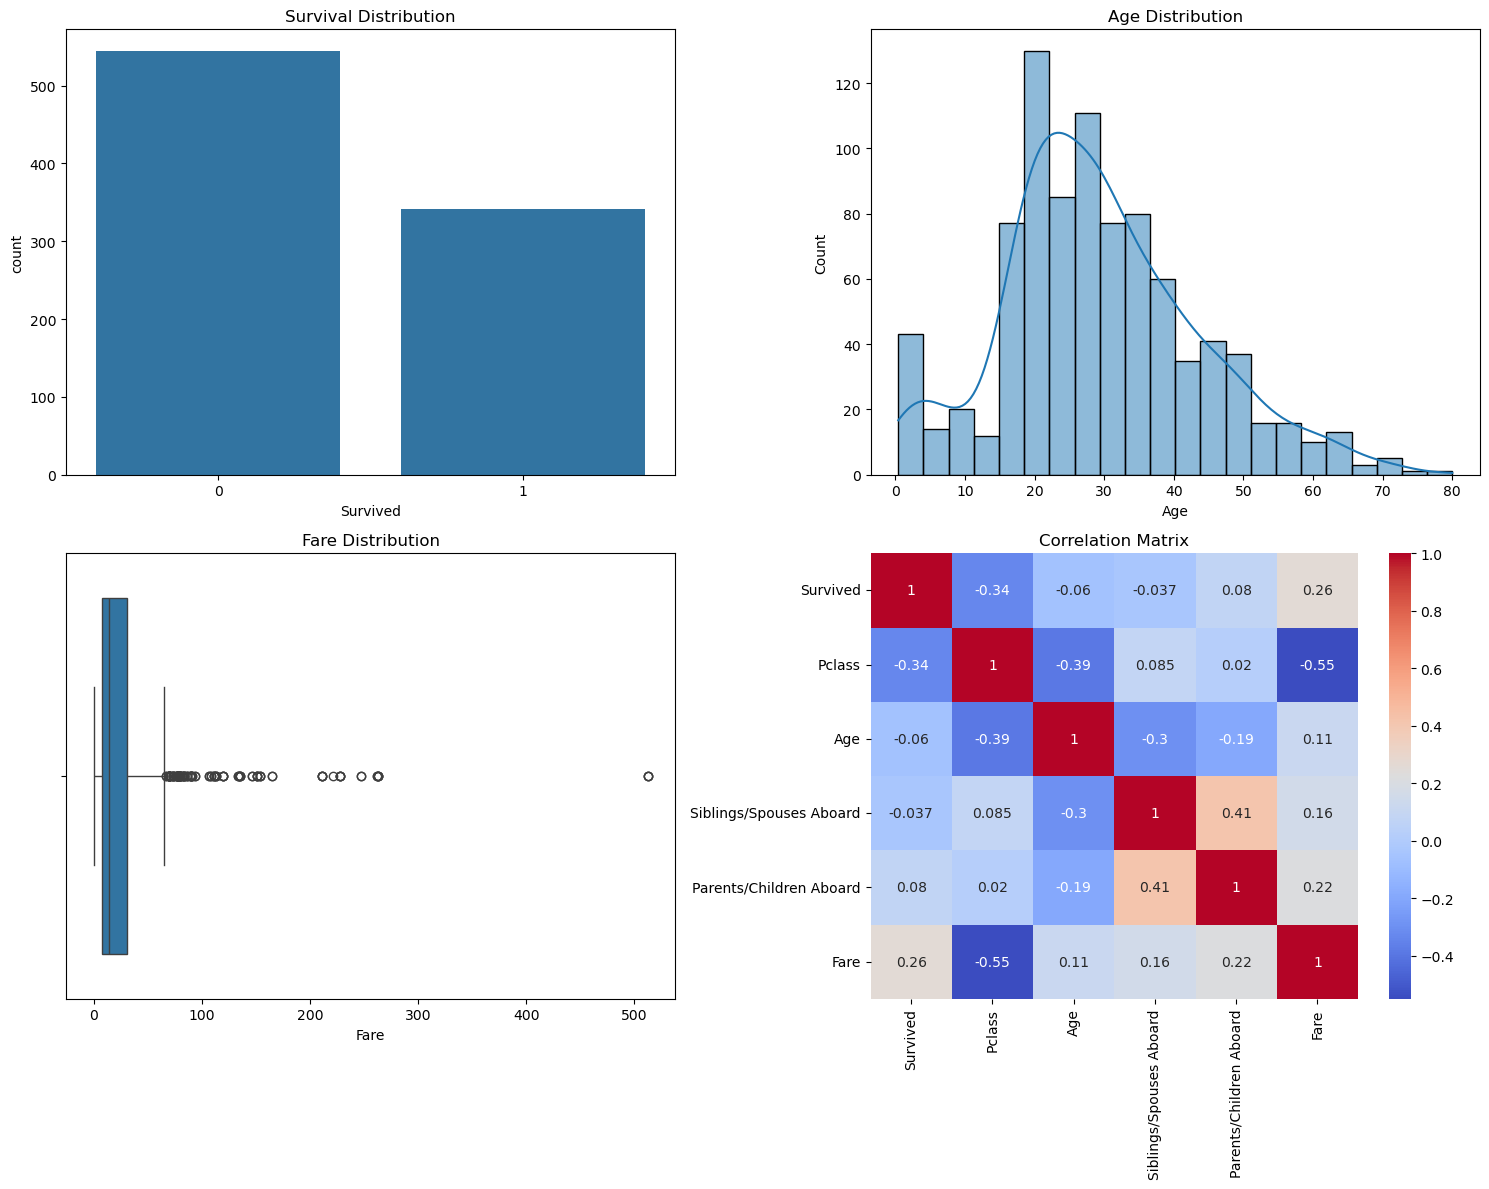

In [4]:
plt.figure(figsize=(15,12))

plt.subplot(2,2,1)
sns.countplot(x='Survived', data=df)
plt.title('Survival Distribution')

plt.subplot(2,2,2)
sns.histplot(df['Age'].dropna(), kde=True)
plt.title('Age Distribution')

plt.subplot(2,2,3)
sns.boxplot(x=df['Fare'])
plt.title('Fare Distribution')

plt.subplot(2,2,4)
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')

plt.tight_layout()
plt.show()

## 3. Data Assessment

In [5]:
print("\n=== Data Quality Issues ===")
print("Missing values:")
print(df.isnull().sum()[df.isnull().sum() > 0])
print("\nDuplicate rows:", df.duplicated().sum())


=== Data Quality Issues ===
Missing values:
Series([], dtype: int64)

Duplicate rows: 0


## 4. Data Cleaning

In [7]:
# Handle outliers
Q1 = df['Fare'].quantile(0.25)
Q3 = df['Fare'].quantile(0.75)
IQR = Q3 - Q1
df = df[(df['Fare'] >= Q1 - 1.5*IQR) & (df['Fare'] <= Q3 + 1.5*IQR)]

print("\nAfter cleaning:")
print("New shape:", df.shape)


After cleaning:
New shape: (771, 8)


## 5. Post-Cleaning Visualization

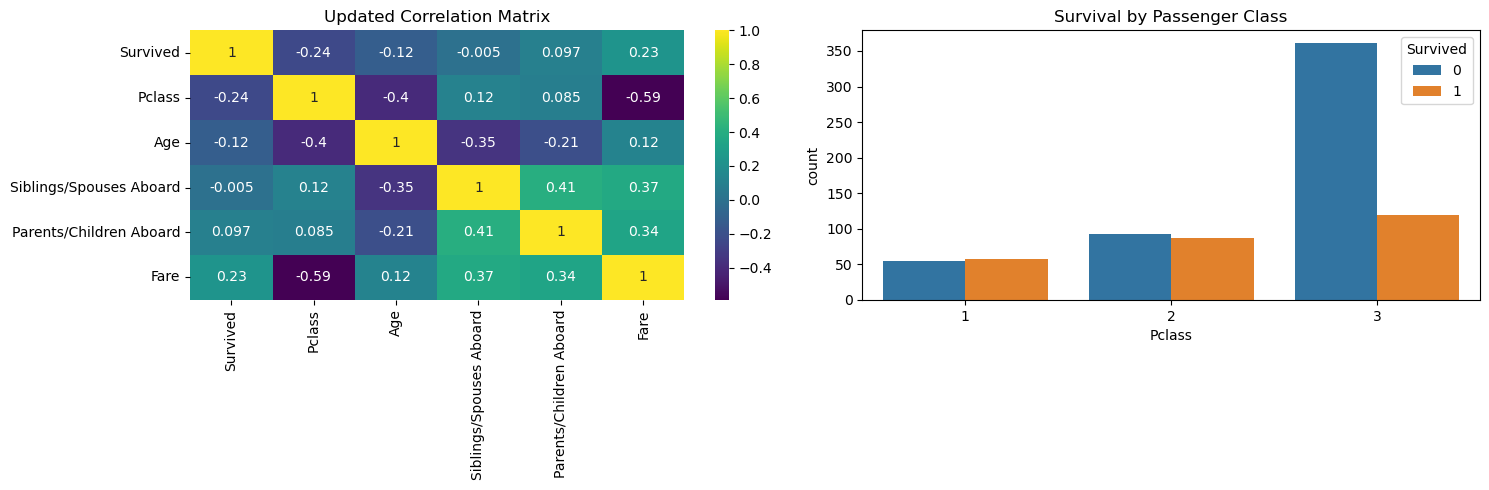

In [8]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='viridis')
plt.title('Updated Correlation Matrix')

plt.subplot(1,2,2)
sns.countplot(x='Pclass', hue='Survived', data=df)
plt.title('Survival by Passenger Class')

plt.tight_layout()
plt.show()

## 6. Data Preprocessing

In [10]:
# Feature engineering
df['FamilySize'] = df['Siblings/Spouses Aboard'] + df['Parents/Children Aboard']

# Define features and target
X = df[['Pclass', 'Sex', 'Age', 'Fare', 'FamilySize']]
y = df['Survived']

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Age', 'Fare', 'FamilySize']),
        ('cat', OneHotEncoder(), ['Sex'])
    ])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

C:\Users\Mostafa.Badr\AppData\Local\Temp\ipykernel_17668\1704084847.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['FamilySize'] = df['Siblings/Spouses Aboard'] + df['Parents/Children Aboard']


## 7. Model Training

In [11]:
model = LogisticRegression(max_iter=1000)
model.fit(preprocessor.fit_transform(X_train), y_train)

LogisticRegression(max_iter=1000)

## 8. Model Evaluation

In [12]:
y_pred = model.predict(preprocessor.transform(X_test))

print("\n=== Model Performance ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


=== Model Performance ===
Accuracy: 0.80

Confusion Matrix:
[[96 10]
 [21 28]]

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.91      0.86       106
           1       0.74      0.57      0.64        49

    accuracy                           0.80       155
   macro avg       0.78      0.74      0.75       155
weighted avg       0.79      0.80      0.79       155



## 9. Model Saving

In [16]:
df.to_csv("data.csv", index=False)
joblib.dump(model, 'titanic_model.pkl')
joblib.dump(preprocessor, 'preprocessor.pkl')

['preprocessor.pkl']

## STREAMLIT DEPLOYMENT CODE

In [17]:
%%writefile st_app.py

import streamlit as st
import joblib
import pandas as pd

# Load artifacts
model = joblib.load('titanic_model.pkl')
preprocessor = joblib.load('preprocessor.pkl')

# App interface
st.title('Titanic Survival Predictor')

# Input widgets
col1, col2 = st.columns(2)
with col1:
    pclass = st.selectbox('Passenger Class', [1, 2, 3])
    sex = st.selectbox('Sex', ['male', 'female'])
    age = st.number_input('Age', min_value=0, max_value=100, value=30)
    
with col2:
    fare = st.number_input('Fare', min_value=0, value=50)
    family_size = st.number_input('Family Size', min_value=0, max_value=10, value=0)

# Prediction logic
if st.button('Predict Survival'):
    input_data = pd.DataFrame([[pclass, sex, age, fare, family_size]],
                            columns=['Pclass', 'Sex', 'Age', 'Fare', 'FamilySize'])
    
    processed_data = preprocessor.transform(input_data)
    prediction = model.predict(processed_data)[0]
    probability = model.predict_proba(processed_data)[0][1]
    
    st.subheader('Result')
    st.metric("Survival Probability", f"{probability:.1%}")
    st.write(f"Prediction: {'Survived' if prediction == 1 else 'Did not survive'}")


# print("\n=== Streamlit App Code ===")
# print("Save this as 'app.py' and run with: streamlit run app.py")
# print(streamlit_code)

Overwriting st_app.py
